# Currents in the Haldane model

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
import numpy as np
from scipy.linalg import eigh
from scipy.optimize import root
import matplotlib.pyplot as plt
import matplotlib as mpl
# For Voronoi plots
from scipy.spatial import Voronoi
import matplotlib as mpl
import matplotlib.cm as cm

from lattice import OpenLattice, HexagonalLattice
from hamiltonian import OpenHamiltonian
from plot_lattice import plot_voronoi

In [3]:
mpl.rcParams['text.usetex'] = True

## Hamiltonian parameters

Hamiltonian:

$$ H = \sum_{ij} A_{ij}\ c^\dagger_i c_j = t_1 \sum_{\langle ij\rangle} c^\dagger_i c_j + t_2 \sum_{\langle\langle ij\rangle\rangle} e^{i\phi_{ij}} c^\dagger_i c_j $$

In [43]:
# Lattice sizes
Nx = Ny = 40
lattice = OpenLattice(Nx, Ny)

# Haldane Hamiltonian's parameters
t1 = 1
t2 = 1
dphi = 0.5
lattice_imbalance = 0

# Harmonica trap strength
trap_potential = 1/50

hopping_params = (t1, t2, dphi)
hoppings_type = 'haldane'
ham = OpenHamiltonian(lattice, hopping_params, hoppings_type,
                      trap_potential, lattice_imbalance)

print(f'Number of sites = {lattice.L}')

Number of sites = 3200


## Hamiltonian diagonalization

$$ H = \sum_{ij} c^\dagger_i A_{ij} c_j = \sum_{ij} c^\dagger_i V_{im} D_m V^*_{jm} c_j = \sum_m f^\dagger_m D_m f_m $$

Therefore the new basis is

$$f^\dagger_m = \sum_i V_{im} c^\dagger_i,\quad f_m = \sum_i V^*_{im} c_i $$

The occupation numbers of these new basis at a finite temperature $\beta$ are given by the Fermi-Dirac distribution

$$ \langle f^\dagger_m f_n \rangle = \delta_{mn}\frac{1}{1+e^{\beta(E_m - \mu)}}$$

with $E_m$ the eigenenergy of $f^\dagger_m$ and $\mu$ the chemical potential, which we must adjust so that the number of particles equals a chose one

$$ \langle N(\mu)\rangle = \sum_m \langle f^\dagger_m f_m \rangle = \sum_m \frac{1}{1+e^{\beta(E_m - \mu)}}$$

The expected values of the two-body operators at finite temperature are

$$ \Gamma_{ij} = \langle c^\dagger_i c_j\rangle = \sum_{mn} V^*_{im} V_{jn} \langle f^\dagger_m f_n\rangle = \sum_m V^*_{im} V_{jm} \frac{1}{1+e^{\beta (E_m - \mu)}}$$

In [5]:
w_eig, v_eig = eigh(ham.A)

In [6]:
def particle_number_with_mu(μ, w, β, N):
    """Particle number with a given chemical potential.
    
    Args:
        μ (float): chemical potential.
        w (1darray of floats): single-particle Hamiltonian spectrum.
        β (float): inverse temperature.
        N (int or float): expected number of particles.
        
    Returns:
        (float): deviation of the particle number with μ with respect
            to N.
            
    """
    return np.sum(1/(1+np.exp(β*(w-μ)))) - N

def compute_Γ(β, N):
    """Compute the expectation values at temperature β with N particles."""

    μ_0 = (w_eig[N-1] + w_eig[N])/2
    sol = root(particle_number_with_mu, μ_0, args=(w_eig, β, N))
    μ = sol.x

    # Fermi-Dirac distribution
    fd_dist = 1/(1 + np.exp(β*(w_eig-μ)))
    
    Γ = np.einsum('im,jm,m->ij', np.conj(v_eig), v_eig, fd_dist, optimize=True)
    return Γ

In [7]:
# Choose a temperature and a particle number to compute the currents
β = 100
N = 650

Γ = compute_Γ(β, N)

## Occupation numbers


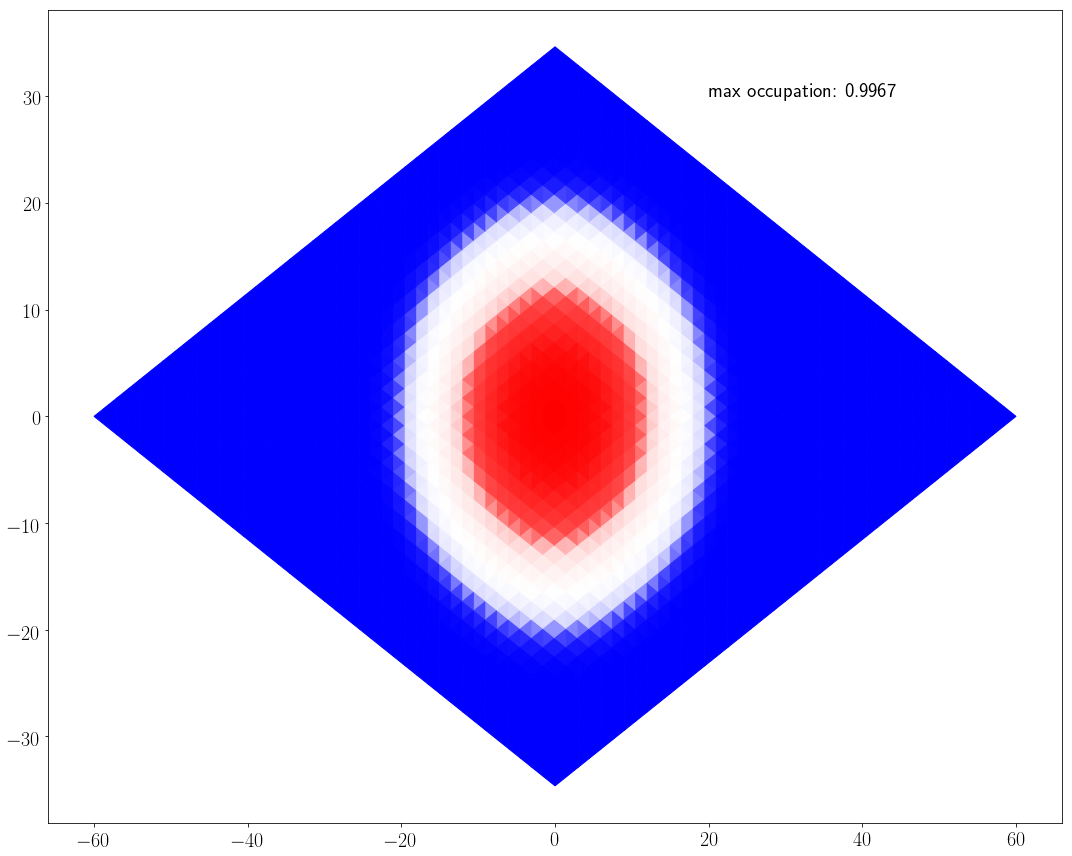

In [58]:
occupations = np.real(np.diag(Γ))

fig = plt.figure(figsize=(15, 12))
norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap='bwr')

fill_coords = np.zeros((lattice.L, 3, 2), np.float64)
disp_A = np.array([[-1, 0], [1/2, np.sqrt(3)/2], [1/2, -np.sqrt(3)/2]])
disp_B = np.array([[1, 0], [-1/2, np.sqrt(3)/2], [-1/2, -np.sqrt(3)/2]])
for i in range(lattice.L):
    if lattice.lat_coords[i, 2] == 0:
        fill_coords[i] = lattice.xy_coords[i] + disp_A
    else:
        fill_coords[i] = lattice.xy_coords[i] + disp_B
    plt.fill(fill_coords[i, :, 0], fill_coords[i, :, 1],
             color=mapper.to_rgba(occupations[i]), alpha=1)
    
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.text(20, 30, r'max occupation: {}'.format(np.round(np.max(occupations), 4)), fontsize=20)
plt.tight_layout()
plt.savefig('./images/real_space_densities.pdf')
plt.show()

## Currents

The time variation of the occupation number is
$$ \langle\frac{d}{dt}n_i\rangle = -i\langle\left[n_i,\ H\right]\rangle = -i\left(\sum_j A_{ij}\ \langle c^\dagger_i c_j\rangle - A_{ji}\ \langle c^\dagger_j c_i\rangle\right) = 2\sum_j \textit{Im} \left[A_{ij}\ \langle c^\dagger_i c_j\rangle\right]= 2\sum_j \textit{Im} \left[A_{ij}\ \Gamma_{ij}\right]$$

The current flowing from site $i$ to site $j$ can be defined as

$$ J_{ij} = 2\ \textit{Im}\left[ A_{ij}\ \langle c^\dagger_i c_j\rangle\right] = 2\ \textit{Im}\left[ A_{ij}\ \Gamma_{ij}\right] $$

The current conservation law is thus conserved as

$$ \langle\frac{d}{dt}n_i\rangle = \sum_j J_{ij} = 0$$

We will define the average direction of the current at a point $i$ as the average of all outgoing currents at that point

$$ \bar{x}_i = \frac{\sum_{j:\ J_{ij}>0} (\vec{x}_j - \vec{x}_i) J_{ij}}{\sum_{j:\ J_{ij}>0} J_{ij}} $$

and the total outgoing current from a point as

$$ \bar{J}_i = \sum_{j:\ J_{ij}>0} J_{ij} $$


In [9]:
def compute_currents(A, Γ):
    """Compute the currents of the model.
    
    Args:
        A (2darray of floats): hopping matrix.
        Γ (2darray of floats): expectation values of the ground state.
        
    Returns:
        x, y, u, v, c (1darrays of floats): current vectors as input for
            quiver plots.
        
    """
    currents = 2*np.imag(ham.A*Γ)
    
    ij = np.nonzero(currents > 0)

    x = lattice.xy_coords[ij[0], 0]
    y = lattice.xy_coords[ij[0], 1]
    u = lattice.xy_coords[ij[1], 0] - x
    v = lattice.xy_coords[ij[1], 1] - y
    c = currents[ij]
    
    return x, y, u, v, c

def compute_average_current_directions(A, Γ):
    currents = 2*np.imag(ham.A*Γ)

    x = lattice.xy_coords[:, 0]
    y = lattice.xy_coords[:, 1]
    u = np.zeros(lattice.L, np.float64)
    v = np.zeros(lattice.L, np.float64)
    c = np.zeros(lattice.L, np.float64)

    for i in range(lattice.L):
        j = np.nonzero(currents[i] > 1e-7)[0]
        if len(j) > 0:
            u[i] = np.sum(currents[i, j]*lattice.xy_coords[j, 0])/np.sum(currents[i, j]) - x[i]
            v[i] = np.sum(currents[i, j]*lattice.xy_coords[j, 1])/np.sum(currents[i, j]) - y[i]
            c[i] = np.sum(currents[i, j])

    return x, y, u, v, c

### Current flowing through a line

In [10]:
def flow_through_line(x, y, u, v, A, Γ, do_visualization=False):
    """Compute total current flowing through a line whose
    coordinates are (x, y), (x+u, y+v).
    
    Notation: every straight line is represented by a 
    pair of numbers: y = a*x + b.
    """
    flux = 0
    J = 2*np.imag(ham.A*Γ)
    
    # Coordinates of the line.
    a = v/u
    c = y - a*x
    θ = np.arctan2(v, u)
    
    # Select all points within a reasonable distance from
    # the line.
    line_center = np.array([x + u/2, y + v/2])
    radius = np.sqrt(u**2/4 + v**2/4) + 2
    distance = np.linalg.norm(lattice.xy_coords - line_center, axis=1)
    ix_mask = np.nonzero(distance < radius)[0]
    
    # Divide points in above or belowe the line.
    # Note: the A points always contain the point (0, +inf), while the 
    # B points always contain (0, -inf). The flux goes from A to B.
    pts_A = ix_mask[np.nonzero((lattice.xy_coords[ix_mask, 1] 
                                - lattice.xy_coords[ix_mask, 0]*a - c) > 1e-4)]
    pts_B = ix_mask[np.nonzero((lattice.xy_coords[ix_mask, 1] 
                                - lattice.xy_coords[ix_mask, 0]*a - c) < -1e-4)]
    
    # Run through every pair of points A and B.
    for pt_a in pts_A:
        for pt_b in pts_B:
            # Coordinates of the line from 1 to 2.
            x1, y1 = lattice.xy_coords[pt_a]
            x2, y2 = lattice.xy_coords[pt_b]
            
            # Check that the current from 1 to 2 crosses the line.
            # x coordinate of the line crossing.
            if not np.isclose(x1, x2):
                a12 = (y1 - y2)/(x1 - x2)
                c12 = y1 - a12*x1
                x_cross = - (c - c12)/(a - a12)
            else:
                x_cross = x1
            crosses_line = ((x_cross > x) and (x_cross < x+u))
            
            if crosses_line:
                θ12 = np.arctan2(y2 - y1, x2 - x1)
                flux += J[pt_a, pt_b]*np.sin(θ - θ12)

    # Visualization.
    if do_visualization:
        tmp_currents = compute_currents(A, Γ)
        plt.quiver(*tmp_currents, cmap='Blues', scale=1, 
                   units='xy', angles='xy', scale_units='xy')
        plt.plot([x, x+u], [y, y+v], 'r')
        plt.xlim([x-2, x+u+2])
        plt.ylim([y-2, y+v+2])
        plt.show()

    return flux

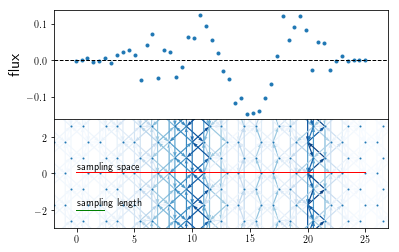

In [11]:
x_vals = np.linspace(-0.1, 25, 50)
sample_length = 2.5
flux = np.zeros_like(x_vals)
for ix, x in enumerate(x_vals):
    flux[ix] = flow_through_line(x, 0.1, sample_length, 0, ham.A, Γ)

ax1 = plt.subplot(211)
plt.plot(x_vals, flux, '.')
plt.ylabel('flux', fontsize=16)
plt.axhline(0, linestyle='dashed', linewidth=1, c='k')
plt.setp(ax1.get_xticklabels(), visible=False)

ax2 = plt.subplot(212, sharex=ax1)
tmp_currents = compute_currents(ham.A, Γ)
plt.quiver(*tmp_currents, cmap='Blues', scale=1, 
           units='xy', angles='xy', scale_units='xy', width=0.1)
plt.scatter(lattice.xy_coords[:, 0], lattice.xy_coords[:, 1], s=1)
plt.xlim([-2, 27])
plt.ylim([-3, 3])
plt.plot([x_vals[0], x_vals[-1]], [0.1, 0.1], 'r', linewidth=1)
plt.text(0, 0.2, 'sampling space')
plt.plot([x_vals[0], x_vals[0]+sample_length], [-2, -2], 'g', linewidth=1)
plt.text(0, -1.8, 'sampling length')

plt.subplots_adjust(hspace=0)
plt.savefig('./images/currents_through_line.pdf')
plt.show()

In [12]:
β_values = np.array([0.1, 0.3, 1, 3, 10, 30])
x_vals = np.linspace(-0.1, 25, 40)
sample_length = 2.5
flux = np.zeros((np.size(β_values), np.size(x_vals)))
for iβ, β in enumerate(β_values):
    Γβ = compute_Γ(β, N)
    for ix, x in enumerate(x_vals):
        flux[iβ, ix] = flow_through_line(x, 0.1, sample_length, 0, ham.A, Γβ)

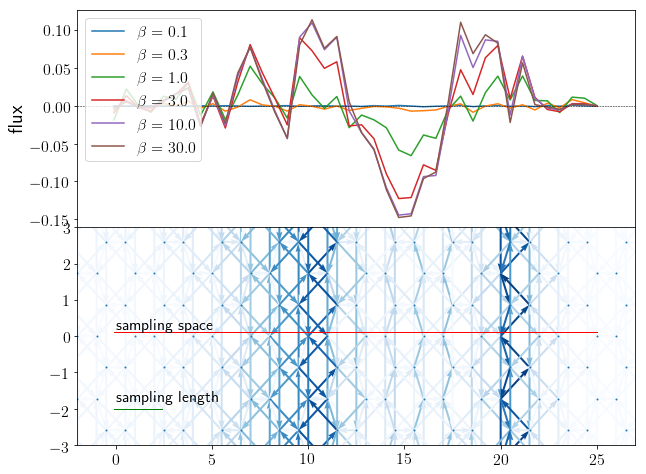

In [13]:
plt.figure(figsize=(10, 8))
ax1 = plt.subplot(211)
for iβ, β in enumerate(β_values):
    plt.plot(x_vals, flux[iβ], 'C{}'.format(iβ), label=r'$\beta = {:2.1f}$'.format(β))
plt.ylabel(r'flux', fontsize=20)
plt.legend(fontsize=16, loc=2)
plt.axhline(0, linestyle='dashed', linewidth=0.5, c='k')
plt.setp(ax1.get_xticklabels(), visible=False)
plt.yticks(fontsize=16)

ax2 = plt.subplot(212, sharex=ax1)
tmp_currents = compute_currents(ham.A, Γ)
plt.quiver(*tmp_currents, cmap='Blues', scale=1, 
           units='xy', angles='xy', scale_units='xy', width=0.1)
plt.scatter(lattice.xy_coords[:, 0], lattice.xy_coords[:, 1], s=1)
plt.xlim([-2, 27])
plt.ylim([-3, 3])
plt.plot([x_vals[0], x_vals[-1]], [0.1, 0.1], 'r', linewidth=1)
plt.text(0, 0.2, 'sampling space', fontsize=16)
plt.plot([x_vals[0], x_vals[0]+sample_length], [-2, -2], 'g', linewidth=1)
plt.text(0, -1.8, 'sampling length', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.subplots_adjust(hspace=0)
plt.savefig('./images/temperature_currents_through_line.pdf')
plt.show()

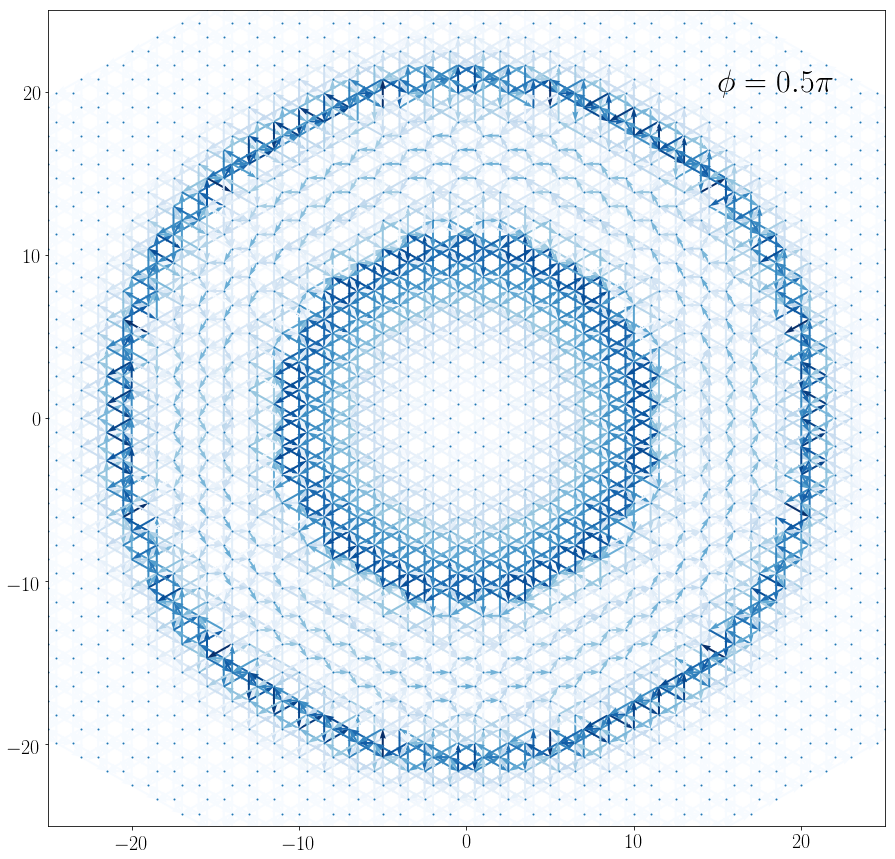

In [59]:
tmp_currents = compute_currents(ham.A, Γ)
fig = plt.figure(figsize=(15, 15))
plt.quiver(*tmp_currents, cmap='Blues', scale=1, units='xy', angles='xy', scale_units='xy')
plt.scatter(lattice.xy_coords[:, 0], lattice.xy_coords[:, 1], s=1)
plt.text(15, 20, r'$\phi = {}\pi$'.format(dphi), fontsize=32)
plt.xlim([-25, 25])
plt.ylim([-25, 25])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.savefig('./images/currents.pdf')
plt.show()

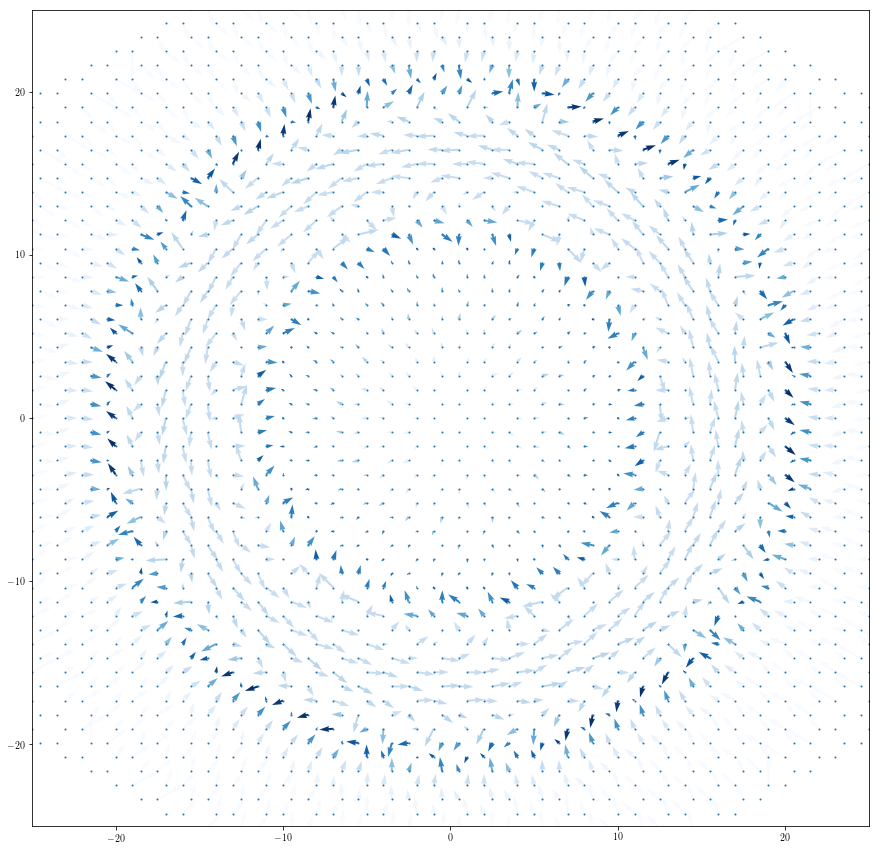

The direction of the arrows shows the average direction of all outgoing currents from that point and the color shows how strong is that current.


In [15]:
tmp_currents = compute_average_current_directions(ham.A, Γ)
fig = plt.figure(figsize=(15, 15))
plt.quiver(*tmp_currents, cmap='Blues', scale=1, units='xy', angles='xy', scale_units='xy')
plt.scatter(lattice.xy_coords[:, 0], lattice.xy_coords[:, 1], s=1)
plt.xlim([-25, 25])
plt.ylim([-25, 25])
plt.show()

print('The direction of the arrows shows the average direction of all outgoing currents from that point and the color shows how strong is that current.')

### Occupations and currents

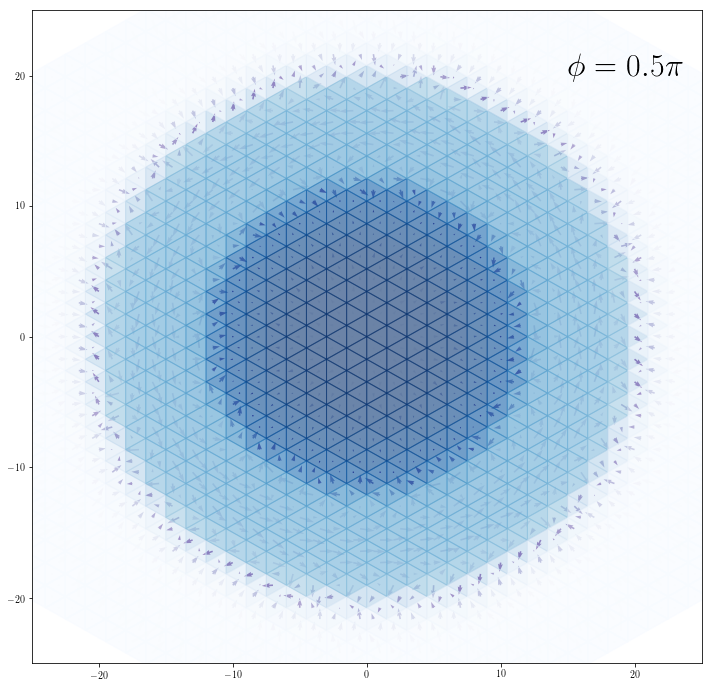

In [16]:
plt.figure(figsize=(12, 12))

data = occupations
norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap='Blues')

fill_coords = np.zeros((lattice.L, 3, 2), np.float64)
disp_A = np.array([[-1, 0], [1/2, np.sqrt(3)/2], [1/2, -np.sqrt(3)/2]])
disp_B = np.array([[1, 0], [-1/2, np.sqrt(3)/2], [-1/2, -np.sqrt(3)/2]])
for i in range(lattice.L):
    if lattice.lat_coords[i, 2] == 0:
        fill_coords[i] = lattice.xy_coords[i] + disp_A
    else:
        fill_coords[i] = lattice.xy_coords[i] + disp_B
    plt.fill(fill_coords[i, :, 0], fill_coords[i, :, 1],
             color=mapper.to_rgba(data[i]), alpha=0.6)

plt.quiver(*tmp_currents, cmap='Purples', scale=1, units='xy', angles='xy', scale_units='xy')
plt.text(15, 20, r'$\phi = {}\pi$'.format(dphi), fontsize=32)
plt.xlim([-25, 25])
plt.ylim([-25, 25])
plt.show()

### Chiral currents

To better observe the currents in the system we should plot total currents going through closed paths, like the closed triangle connecting all sites of a particular sublattice in one hexagon, both triangles, or both triangles and the current going through the edges of the hexagon. 

#### Coordinates of every closed hexagon in the lattice

In [17]:
# Relative coordinates of a single hexagon with respect to the lower left point.
hex_coords = np.array([[0, 0, 0], [-1, 0, 1], [-1, 1, 0],
                       [-1, 1, 1], [0, 1, 0], [0, 0, 1]], np.int64)

# Array with the indices of every point in every hexagon.
hexagons = []
for i in range(0, lattice.L):
    # Starting point of the hexagon must be in sublattice A.
    if lattice.lat_coords[i, 2] != 0:
        continue
    i_coord = lattice.lat_coords[i]
    # Indices of the points that define an hexagon. If some index is -1, the hexagon is open.
    hex_ix = np.zeros(6, np.int64)
    for j in range(6):
        hex_ix[j] = lattice.position_to_index(i_coord + hex_coords[j])
    # Count only closed hexagons.
    if not np.any(hex_ix < 0):
        hexagons.append(hex_ix)
hexagons = np.array(hexagons, np.int64)

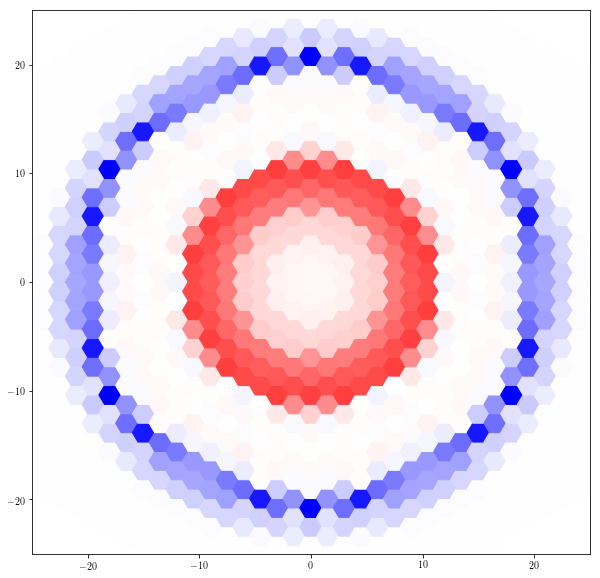

In [18]:
# Circular currents
currents = 2*np.imag(ham.A*Γ)
circular_currents = np.zeros(hexagons.shape[0], np.float64)
for i in range(hexagons.shape[0]):
    for j in range(6):
        # First neighbor currents.
        circular_currents[i] += currents[hexagons[i, (j+1)%6], hexagons[i, j]]
    for j in range(3):
        # Sublattice A second neighbor currents.
        circular_currents[i] += currents[hexagons[i, (2*j+2)%6], hexagons[i, 2*j]]
        # Sublattice B second negihbor currents.
        circular_currents[i] += currents[hexagons[i, (2*j+3)%6], hexagons[i, 2*j+1]]

data = circular_currents
max_abs_data = np.max(np.abs(data))
norm = mpl.colors.Normalize(vmin=-max_abs_data, vmax=max_abs_data,
                            clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap='bwr')
        
plt.figure(figsize=(10, 10))
for i in range(hexagons.shape[0]):
    plt.fill(lattice.xy_coords[hexagons[i], 0], lattice.xy_coords[hexagons[i], 1],
             color=mapper.to_rgba(data[i]))
plt.xlim([-25, 25])
plt.ylim([-25, 25])
plt.show()

## Time of flight images

Let's suppose we release the optic trap that simulated the Haldane model. We can consider that the particles will then expand as plane waves without interference between them. Therefore, the momentum distribution after we have released them from the trap will be

$$ \langle \psi^\dagger (\vec{k})\ \psi (\vec{k})\rangle \sim \sum_{ij} e^{i\vec{k}(\vec{x}_i - \vec{x}_j)} \langle a^\dagger_i a_j \rangle $$

This computation can be numerically done with ease if we first define a matrix

$$ U_{ki} = e^{-i\vec{k}\vec{x}_i}$$

Therefore

$$ \Gamma^{TOF}_{kk} = \langle \psi^\dagger (\vec{k})\ \psi (\vec{k})\rangle \sim \sum_{ij} U_{ki} \langle a^\dagger_i a_j \rangle U^*_{kj} $$

### Brillouin zone

The displacement vectors between unit cells in real space are

$$ \vec{a}_x = (3/2, -\sqrt{3}/2),\quad \vec{a}_y = (3/2, \sqrt{3}/2) $$

The basis vectors of the Brillouin zone are those that satisfy $a_i \cdot g_j = \delta_{ij}$ with $i,j = \lbrace x,y\rbrace$, therefore,

$$ \vec{g}_x = (1/3, -1/\sqrt{3}),\quad \vec{g}_y = (1/3, 1/\sqrt{3}) $$ 

Thus, the Brillouin zone is the region inside the vertices $(-\pi\vec{g}_x - \pi\vec{g}_y,\ -\pi\vec{g}_x + \pi\vec{g}_y,\ \pi\vec{g}_x - \pi\vec{g}_y,\ \pi\vec{g}_x + \pi\vec{g}_y)$, which has its origin at $\vec{k} = 0$

**UPDATE**

Surprisingly the vectors mentioned above do not give the correct form of the Brillouin zone. We can get the right one by using instead the following vectors

$$ \vec{g}_x = (1, -1/\sqrt{3}),\quad \vec{g}_y = (0, -2/\sqrt{3}), $$ 

which imply that the real lattice displacement vectors are

$$ \vec{a}_x = (1, 0),\quad \vec{a}_y = (-1/2, -\sqrt{3}/2). $$

This could mean that the Hamiltonian having open boundary condition implies that the symmetry of the lattice is no longer the symmetry of one sublattice (A or B), but the symmetry of the individual positions, wheter in the sublattice A or B.

In [63]:
def compute_fourier_matrix(lattice, grid_dims):
    """Compute the U matrix of the Fourier transform and the positions in
    momentum space.
    """
    # Indices of the points
    ikx, iky = np.meshgrid(np.linspace(-np.pi, np.pi, grid_dims), 
                           np.linspace(-np.pi, np.pi, grid_dims))
    # XY coordinates in the Brillouin zone
    kx = ikx
    ky = -ikx/np.sqrt(3) - iky*2/np.sqrt(3)

    # U matrix
    kxr = np.ravel(kx)
    kyr = np.ravel(ky)
    xi = lattice.xy_coords[:, 0]
    yi = lattice.xy_coords[:, 1]
    U = np.exp(-1j*(np.outer(kxr, xi) + np.outer(kyr, yi)))/grid_dims

    return U, ikx, iky, kx, ky

    
def plot_full_TOF_images(lattice, Γ, grid_dims):
    """Plot the TOF images that result from releasing the whole lattice at once, 
    only sublattice A, and only sublattice B.
    """
    U, ikx, iky, _, _ = compute_fourier_matrix(lattice, grid_dims)
    
    # Releasing both sublattices
    Γ_tof = np.real(np.einsum('ki,ij,kj->k', U, Γ, np.conj(U), optimize=True))
    im_Γ_tof = np.reshape(Γ_tof, (grid_dims, grid_dims))

    # Releasing sublattice A
    Ua = np.copy(U)
    Ua[:, np.arange(1, lattice.L, 2)] = 0
    Γ_tof_a = np.real(np.einsum('ki,ij,kj->k', Ua, Γ, np.conj(Ua), optimize=True))
    im_Γ_tof_a = np.reshape(Γ_tof_a, (grid_dims, grid_dims))

    # Releasing sublattice B
    Ub = np.copy(U)
    Ub[:, np.arange(0, lattice.L, 2)] = 0
    Γ_tof_b= np.real(np.einsum('ki,ij,kj->k', Ub, Γ, np.conj(Ub), optimize=True))
    im_Γ_tof_b = np.reshape(Γ_tof_b, (grid_dims, grid_dims))

    plt.figure(figsize=(30, 8))
    plt.subplot(131)
    plt.title('Releasing both sublattices', fontsize=30)
    plt.pcolormesh(ikx, iky, im_Γ_tof, cmap='inferno', vmin=0)
    plt.xticks(np.linspace(-np.pi, np.pi, 5), 
                   [r'$-\pi$', r'$-\pi/2$', r'$0$', r'$\pi/2$', r'$\pi$'],
                  fontsize=30)
    plt.yticks(np.linspace(-np.pi, np.pi, 5),
               [r'$-\pi$', r'$-\pi/2$', r'$0$', r'$\pi/2$', r'$\pi$'],
              fontsize=30)
    plt.subplot(132)
    plt.title('Releasing sublattice A', fontsize=30)
    plt.pcolormesh(ikx, iky, im_Γ_tof_a, cmap='inferno', vmin=0)
    plt.xticks(np.linspace(-np.pi, np.pi, 5), 
                   [r'$-\pi$', r'$-\pi/2$', r'$0$', r'$\pi/2$', r'$\pi$'],
                  fontsize=30)
    plt.yticks(np.linspace(-np.pi, np.pi, 5),
               [r'$-\pi$', r'$-\pi/2$', r'$0$', r'$\pi/2$', r'$\pi$'],
              fontsize=30)

    plt.subplot(133)
    plt.title('Releasing sublattice B', fontsize=30)
    plt.pcolormesh(ikx, iky, im_Γ_tof_b, cmap='inferno', vmin=0)
    plt.xticks(np.linspace(-np.pi, np.pi, 5), 
                   [r'$-\pi$', r'$-\pi/2$', r'$0$', r'$\pi/2$', r'$\pi$'],
                  fontsize=30)
    plt.yticks(np.linspace(-np.pi, np.pi, 5),
               [r'$-\pi$', r'$-\pi/2$', r'$0$', r'$\pi/2$', r'$\pi$'],
              fontsize=30)
    plt.tight_layout()
    plt.savefig('./images/tof_images.pdf')
    plt.show()
    return 

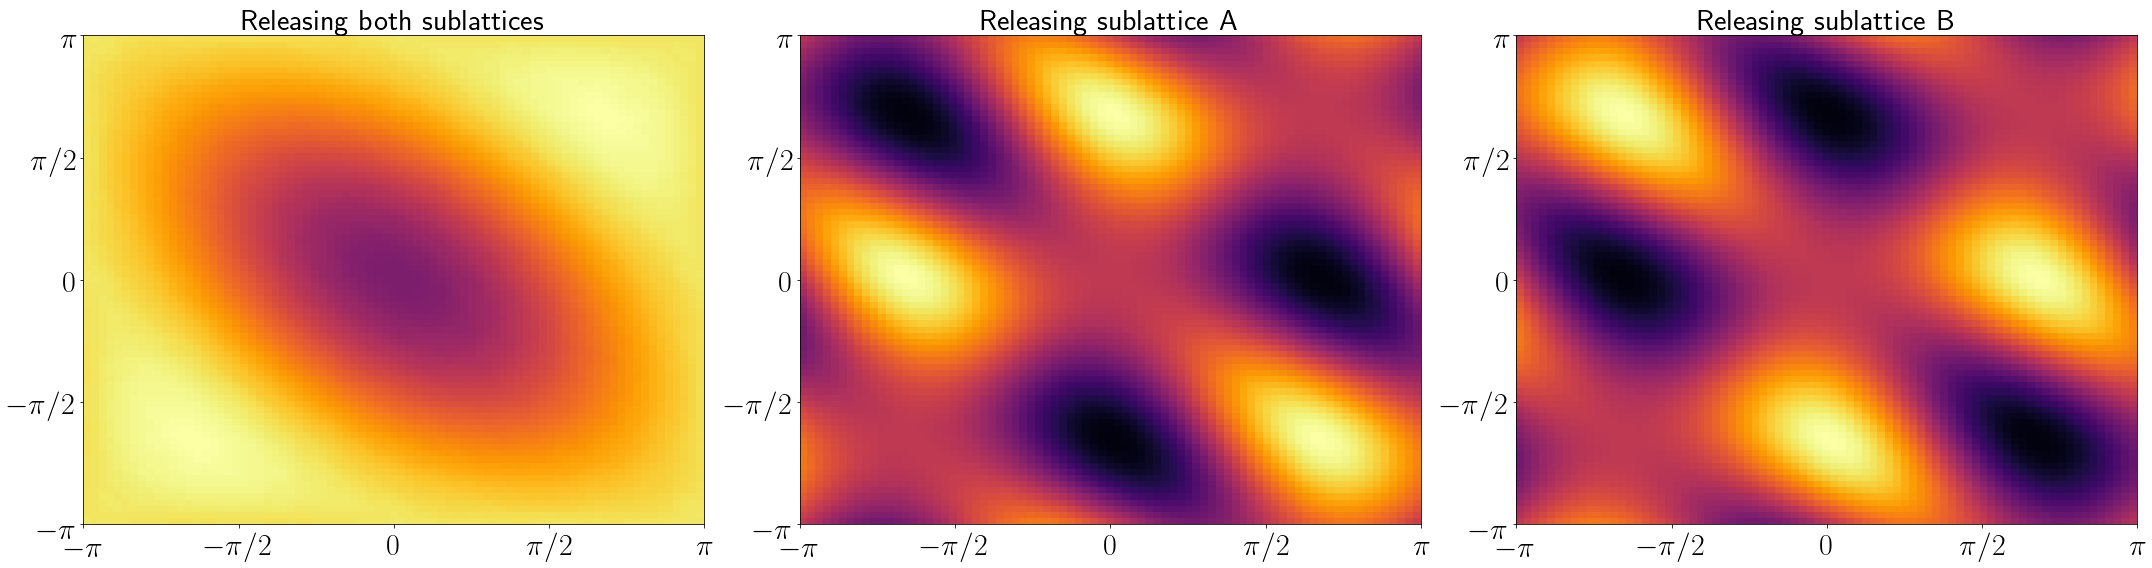

In [64]:
# This will take a while, so you may want to have a smaller grid.
grid_dims_for_full_TOF = 80
plot_full_TOF_images(lattice, Γ, grid_dims_for_full_TOF)

#### TOF of some small set of particles

We can change the spin of some particles and then release them from the trap to observe if their velocity due to the currents in the topological model has any imprint in the TOF images. The TOF is computed as

$$ \Gamma^{TOF,\downarrow}_{kk} = \langle \psi^\dagger (\vec{k})\ \psi (\vec{k})\rangle \sim \sum_{ij} U_{ki} \Gamma^\downarrow_{ij} U^*_{kj} $$

In [21]:
def make_tof_of_spin_down(Γ, R, θ, r, U, kx, ky, grid_dims, plot_tof=False, compute_avg_momentum=True):
    """Flip the spin inside a circle of radius 'r' with center at (R, θ)."""
    # Get the distance of the lattice points to the center of our circle.
    xy_center = np.array([R*np.cos(θ), R*np.sin(θ)])
    distance = np.linalg.norm(lattice.xy_coords - xy_center, axis=1)
    ix_mask = np.nonzero(distance < r)[0]
    
    # Expected values in momentum space
    i_mask, j_mask = np.meshgrid(ix_mask, ix_mask, indexing='ij')
    U_mask = U[:, ix_mask]
    # Remove '0' values to make Fourier transform faster
    Γ_down = Γ[i_mask, j_mask]
    Γ_tof_down = np.real(
        np.einsum('ki,ij,kj->k', U_mask, Γ_down, np.conj(U_mask), 
                  optimize=True)
        )
    im_Γ_tof_down = np.reshape(Γ_tof_down, (grid_dims, grid_dims))
    
    # Mean momentum.
    mean_k = np.array([np.sum(kx*im_Γ_tof_down), np.sum(ky*im_Γ_tof_down)])
    if compute_avg_momentum:
        mean_k /= np.sum(im_Γ_tof_down) + 0.1

    if plot_tof:
        # Plots.
        plt.figure(figsize=(15, 7))
        # Spin down particles.
        plt.subplot(121)
        plt.quiver(x, y, u, v, c, cmap='Blues', 
                   scale=1, units='xy', angles='xy', scale_units='xy', 
                   width=0.1, zorder=2)
        plt.scatter(lattice.xy_coords[ix_mask, 0], lattice.xy_coords[ix_mask, 1], 
                    s=100, c='r')

        # Set the picture limits.
        tmp_max_x = np.max(lattice.xy_coords[ix_mask, 0])
        tmp_min_x = np.min(lattice.xy_coords[ix_mask, 0])
        tmp_max_y = np.max(lattice.xy_coords[ix_mask, 1])
        tmp_min_y = np.min(lattice.xy_coords[ix_mask, 1])
        tmp_length = np.max([10, tmp_max_x - tmp_min_x])
        tmp_height = np.max([10, tmp_max_y - tmp_min_y])
        plt.xlim([tmp_min_x - 0.5*tmp_length, tmp_max_x + 0.5*tmp_length])
        plt.ylim([tmp_min_y - 0.5*tmp_height, tmp_max_y + 0.5*tmp_height])
        plt.tick_params(axis='both', which='major', labelsize=20)
        plt.tick_params(axis='both', which='minor', labelsize=20)

        # TOF images.
        plt.subplot(122)
        plt.title('Releasing the spin down population', fontsize=20)
        plt.pcolormesh(ikx, iky, im_Γ_tof_down, cmap='inferno')
        plt.xticks(np.linspace(-np.pi, np.pi, 5), 
                   [r'$-\pi$', r'$-\pi/2$', r'$0$', r'$\pi/2$', r'$\pi$'],
                  fontsize=20)
        plt.yticks(np.linspace(-np.pi, np.pi, 5),
                   [r'$-\pi$', r'$-\pi/2$', r'$0$', r'$\pi/2$', r'$\pi$'],
                  fontsize=20)
        cbar = plt.colorbar(ticks=np.linspace(np.min(im_Γ_tof_down)+1e-6, 
                                              np.max(im_Γ_tof_down), 4))
        cbar.ax.tick_params(labelsize=20)

        plt.show()
        
    return mean_k

Reference values for the reversal of spins at 0 temperature are:

* Inner current: $\rho = 11$, $\Delta \rho = 1$
* Outer current: $\rho = 20$, $\Delta \rho = 1$

### Compute currents at different radius and different angles

In [65]:
grid_dims = 100
U, _, _, kx, ky = compute_fourier_matrix(lattice, grid_dims)

R_values = np.linspace(0, 27, 50)
θ_values = np.pi*np.linspace(-1, 1, 6)

avg_k_norm = np.zeros((θ_values.size, R_values.size))
avg_k_angle = np.zeros((θ_values.size, R_values.size))

for iθ, θ in enumerate(θ_values):
    for iR, R in enumerate(R_values):
        avg_kx, avg_ky = make_tof_of_spin_down(Γ, R, θ, 2, U, kx, ky, grid_dims,
                                               compute_avg_momentum=True)
        avg_k_norm[iθ, iR] = np.linalg.norm([avg_kx, avg_ky])
        avg_k_angle[iθ, iR] = np.arctan2(avg_ky, avg_kx) - θ
        if avg_k_angle[iθ, iR] > np.pi:
            avg_k_angle[iθ, iR] -= 2*np.pi
        elif avg_k_angle[iθ, iR] <= -np.pi:
            avg_k_angle[iθ, iR] += 2*np.pi

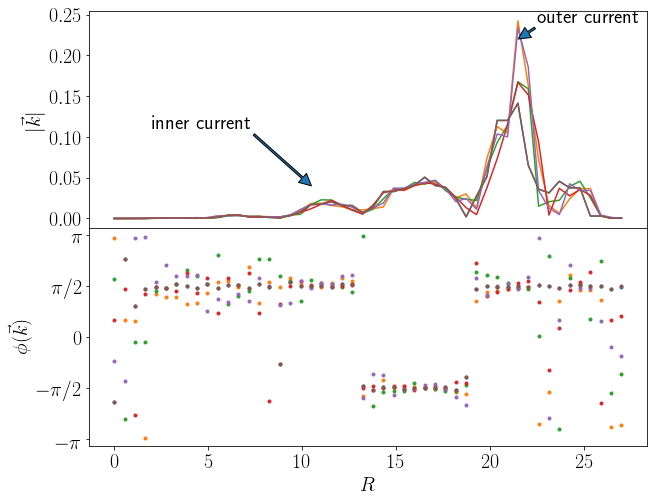

In [69]:
plt.figure(figsize=(10, 8))
# Norm of mean momentum
ax1 = plt.subplot(211)
plt.plot(R_values, avg_k_norm.T)
plt.xlabel(r'$R$', fontsize=20)
plt.ylabel(r'$|\vec{k}|$', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.annotate('inner current', xy=(10.5, 0.04), xytext=(2, 0.11), fontsize=20, 
             arrowprops={'width': 2})
plt.annotate('outer current', xy=(21.5, 0.22), xytext=(22.5, 0.24), fontsize=20, 
             arrowprops={'width': 2})
plt.setp(ax1.get_xticklabels(), visible=False)

# Angle of mean momentum
ax2 = plt.subplot(212, sharex=ax1)
plt.plot(R_values, avg_k_angle.T, '.')
plt.xlabel(r'$R$', fontsize=20)
plt.ylabel(r'$\phi(\vec{k})$', fontsize=20)
plt.ylim([-np.pi-0.2, np.pi+0.2])
plt.xticks(fontsize=20)
plt.yticks(np.linspace(-np.pi, np.pi, 5),
           [r'$-\pi$', r'$-\pi/2$', r'$0$', r'$\pi/2$', r'$\pi$'],
          fontsize=20)

plt.subplots_adjust(hspace=0)
plt.savefig('./images/mean_TOF_momentum_at_different_radius_and_angles.pdf')
plt.show()

### Dependence of the currents with the temperature

In [24]:
R_values = np.linspace(0, 27, 50)
θ = 0
β_values = np.array([0.1, 0.3, 1, 3, 10, 30])
N = 650

avg_k_norm = np.zeros((β_values.size, R_values.size))

for iβ, β in enumerate(β_values):
    Γ = compute_Γ(β, N)
    print(β)
    for iR, R in enumerate(R_values):
        avg_kx, avg_ky = make_tof_of_spin_down(Γ, R, θ, 2, U, kx, ky, grid_dims, 
                                               compute_avg_momentum=False)
        avg_k_norm[iβ, iR] = np.linalg.norm([avg_kx, avg_ky])

0.1
0.3
1.0
3.0
10.0
30.0


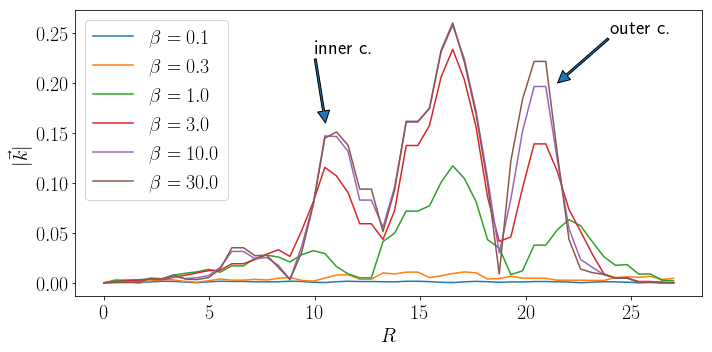

In [25]:
plt.figure(figsize=(10, 5))
for iβ, β in enumerate(β_values):
    plt.plot(R_values, avg_k_norm[iβ], 'C{}'.format(iβ), label=r'$\beta = {:2.1f}$'.format(β))
plt.xlabel(r'$R$', fontsize=20)
plt.ylabel(r'$|\vec{k}|$', fontsize=20)
plt.legend(fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.annotate('inner c.', xy=(10.5, 0.16), xytext=(10, 0.23), fontsize=20, 
             arrowprops={'width': 2})
plt.annotate('outer c.', xy=(21.5, 0.2), xytext=(24, 0.25), fontsize=20, 
             arrowprops={'width': 2})

plt.tight_layout()
plt.savefig('./images/temperature_mean_momentum_spin_down_TOF.pdf')
plt.show()

## Reverting the spin of some particles

We can try to revert the spin of a set of particles and see if their time evolution gives us any information about the topological currents. To do so, we select a subset of particles $X$ that we want to revert the spin and extract them out of the system. We will let them evolve in a Hamiltonian without currents (a graphene model).

Let's suppose we have inverted some spin up particles that are now described by the correlation matrix $\Gamma^\downarrow_{ij} = \langle a^\dagger_{i\downarrow} a_{j\downarrow} \rangle$. We can write this matrix in the eigenbasis of the Hamiltonian $\Gamma^\downarrow_{kk'} = V^\dagger \Gamma^\downarrow_{ij} V$. This has the advantage that the Hamiltonian takes a diagonal form and, therefore, the time evolution takes a much simpler form

$$ \frac{d}{dt}\Gamma^\downarrow_{kk'} = -i\left(E_{k'}- E_k\right)\Gamma^\downarrow_{kk'} $$

therefore

$$ \Gamma^\downarrow_{kk'}(t) = \Gamma^\downarrow_{kk'}(0)\ e^{-i\left(E_{k'}- E_k\right)t}$$

As long as we want to observe movement in position space, we have to write it back in the original basis. Thus

$$ \Gamma^\downarrow_{ij}(t) = \sum_{kk'} V^*_{ik}\ \Gamma^\downarrow_{kk'}(t) V_{jk'} = \sum_{kk'} V^*_{ik}\ \Gamma^\downarrow_{kk'}(0)\ e^{-i\left(E_{k'}- E_k\right)t} V_{jk'} = \sum_{kk'mn} V^*_{ik}V_{mk}\ \Gamma^\downarrow_{mn} (0) V^*_{nk'} V_{jk'}\ e^{-i\left(E_{k'}- E_k\right)t}$$

We can simplilfy the expression by defining

$$ W_{jn} = \sum_k V_{jk}\ e^{-iE_k t}\ V^*_{nk}$$

such that

$$ \Gamma^\downarrow_{ij}(t) = \sum_{mn} W^*_{im}\ \Gamma^\downarrow_{mn}(0)\ W_{jn}$$

#### Hamiltonian without currents

In [20]:
hopping_params = (t1, t2, 0)
ham = OpenHamiltonian(lattice, hopping_params, hoppings_type,
                      trap_potential, lattice_imbalance)
w_eig, v_eig = eigh(ham.A)

#### Initial spin down population

In [21]:
Ω = np.zeros(lattice.L, np.int64)
radius = np.linalg.norm(lattice.xy_coords, axis=1)
angle = np.arctan2(lattice.xy_coords[:, 1], lattice.xy_coords[:, 0])
ix_mask = np.nonzero(np.logical_and(
    np.logical_and(radius >= 20, radius < 21), 
    np.logical_and(angle > 0.3*np.pi, angle <= 0.5*np.pi)
    ))[0]
Ω[ix_mask] = 1

Γ_down = np.outer(Ω, Ω)*Γ
occupations_down = np.real(np.diag(Γ_down))

plt.figure(figsize=(12, 12))
if not np.isclose(np.linalg.norm(c), 0):
    # Currents and spin down population.
    plt.quiver(x, y, u, v, c, cmap='Blues', scale=1, units='xy', angles='xy', scale_units='xy', zorder=2)
    plt.scatter(lattice.xy_coords[ix_mask, 0], lattice.xy_coords[ix_mask, 1], s=100, c='r')
    plt.xlim([-25, 25])
    plt.ylim([-25, 25])
else:
    # Densities and spin down population.
    plot_voronoi(lattice, occupations, colormap='bwr')
    plt.scatter(lattice.xy_coords[ix_mask, 0], lattice.xy_coords[ix_mask, 1], s=100, c='k', zorder=2)
plt.show()

NameError: name 'c' is not defined

<Figure size 864x864 with 0 Axes>

#### Time evolution of the spin down population

In [ ]:
# Final times
times = np.arange(9)

plt.figure(figsize=(20,18))

v_eig_mask = v_eig[ix_mask, :]
for ix, t in enumerate(times):
    print('time: {}'.format(t))
    tmp_exp = np.exp(-1j*w_eig*t)
    i_mask, j_mask = np.meshgrid(ix_mask, ix_mask, indexing='ij')
    Γ_down = Γ[i_mask, j_mask]
    W = np.einsum('jk,k,nk->jn', v_eig, tmp_exp, np.conj(v_eig_mask), 
                  optimize=True)
    occupations_down_t = np.real(
        np.einsum('im,mn,in->i', np.conj(W), Γ_down, W, optimize=True)
        )
    
    data = occupations_down_t

    plt.subplot(3, 3, ix+1)
    
    norm = mpl.colors.Normalize(vmin=0, vmax=np.max(data), clip=True)
    mapper = cm.ScalarMappable(norm=norm, cmap='binary')

    fill_coords = np.zeros((lattice.L, 3, 2), np.float64)
    disp_A = np.array([[-1, 0], [1/2, np.sqrt(3)/2], [1/2, -np.sqrt(3)/2]])
    disp_B = np.array([[1, 0], [-1/2, np.sqrt(3)/2], [-1/2, -np.sqrt(3)/2]])
    for i in range(lattice.L):
        if lattice.lat_coords[i, 2] == 0:
            fill_coords[i] = lattice.xy_coords[i] + disp_A
        else:
            fill_coords[i] = lattice.xy_coords[i] + disp_B
        plt.fill(fill_coords[i, :, 0], fill_coords[i, :, 1],
                 color=mapper.to_rgba(data[i]), alpha=1)
        
    # Mean density
    mean_x = np.sum(occupations_down_t*lattice.xy_coords[:, 0])/np.sum(occupations_down_t)
    mean_y = np.sum(occupations_down_t*lattice.xy_coords[:, 1])/np.sum(occupations_down_t)
    mean_phi = np.arctan2(mean_y, mean_x)
    mean_r = np.sqrt(mean_x**2 + mean_y**2)
    plt.scatter(mean_x, mean_y, s=100, c='r', zorder=2)
    plt.text(-20, 18, r'$t = {}; \phi = {:4.3f}; r = {:4.3f}$'.format(t, mean_phi, mean_r), fontsize=20)
    plt.xlim([-25, 25])
    plt.ylim([-25, 25])
        
plt.show()